****
# PART 1
## Exploratory data analysis
****

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('seaborn-whitegrid')

In [3]:
df = pd.read_json('logins.json', )
df['login_time'] = df['login_time'].sort_values()
df.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


# Data quality issues
The login times are not logged in chronological order. This requires an additional ordering step and introduces the potential for error.

In [4]:
df = df.set_index('login_time')
df['logins'] = 1
df.describe()

,logins
count,93142.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
logins    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [6]:
df.tail()

,logins
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


# Aggregation
The following aggregation converts the irregular time series into a fixed frequency time series of 15 minutes.

## Notes:
```python
week_df = df_15min_span.groupby(df_15min_span['logins'].index.weekday_name).mean()
```
does not give the desired output. This is the average 15 min login value across each day. The desired output is the average number of total logins per weekday.
- A combination of resamplings will be used instead.

In [7]:
df_15min_span = df.resample('15min').count()

In [8]:
week_df = df_15min_span.groupby(df_15min_span['logins'].index.weekday_name).mean()
week_df

,logins
login_time,
Friday,10.561111
Monday,6.213380
Saturday,13.456250
Sunday,12.615972
Thursday,8.794118
Tuesday,6.895833
Wednesday,7.692708


In [10]:
df_15min_span['weekday'] = list(df_15min_span.index.dayofweek)

In [11]:
df_weekdays = df_15min_span[df_15min_span['weekday'].isin([0,1,2,3,4])]
series_weekdays = df_weekdays['logins']

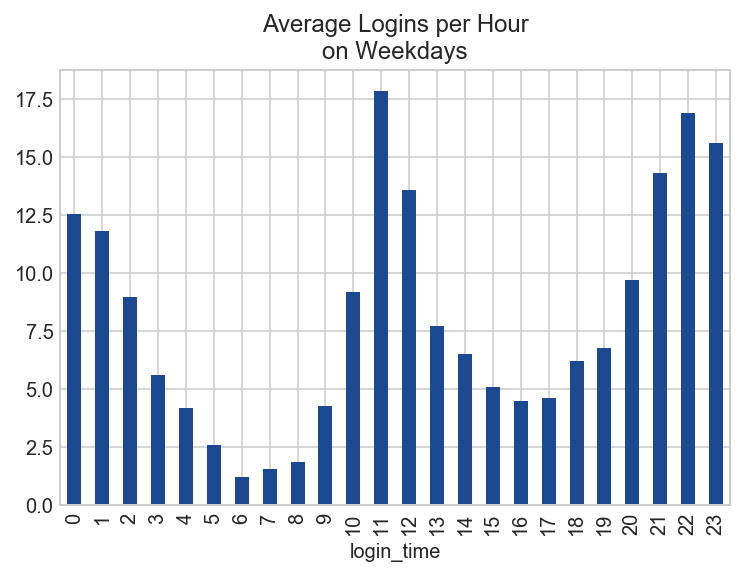

In [12]:
series_weekdays.groupby(series_weekdays.index.hour).mean().plot(kind='bar', 
                                                                title='Average Logins per Hour\non Weekdays',
                                                                color='#1d4991')

In [13]:
df_weekends = df_15min_span[df_15min_span['weekday'].isin([5,6])]
series_weekends = df_weekends['logins']

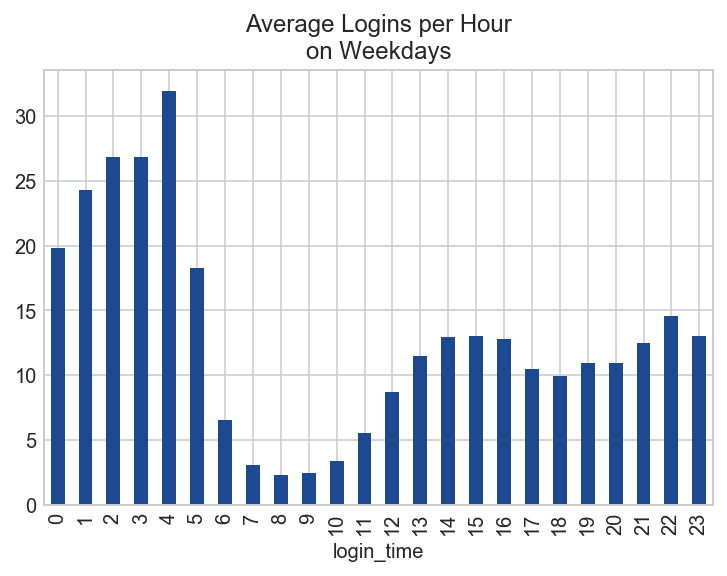

In [14]:
series_weekends.groupby(series_weekends.index.hour).mean().plot(kind='bar', 
                                                                title='Average Logins per Hour\non Weekdays',
                                                                color='#1d4991')

In [15]:
from datetime import timedelta, datetime

In [16]:
def plot_one_week(start_date):
    plt.figure(figsize=(14,14))
    for day in range(1,8):
        plot_date = str(datetime.strptime(start_date, '%Y-%m-%d') + (timedelta(day - 1)))[:11]
        plt.subplot(3,3,day)
        plt.plot(df_15min_span[plot_date])
        plt.xticks([plot_date + '01:00:00', plot_date + '12:00:00', plot_date + '23:00:00'], 
                   ['1AM', 'Noon', '11PM'])
        plt.title('Logins for ' + datetime.strftime(datetime.strptime(start_date, '%Y-%m-%d') + (timedelta(day - 1)), 
                                                    '%A %B, %d %Y'))
    plt.show()

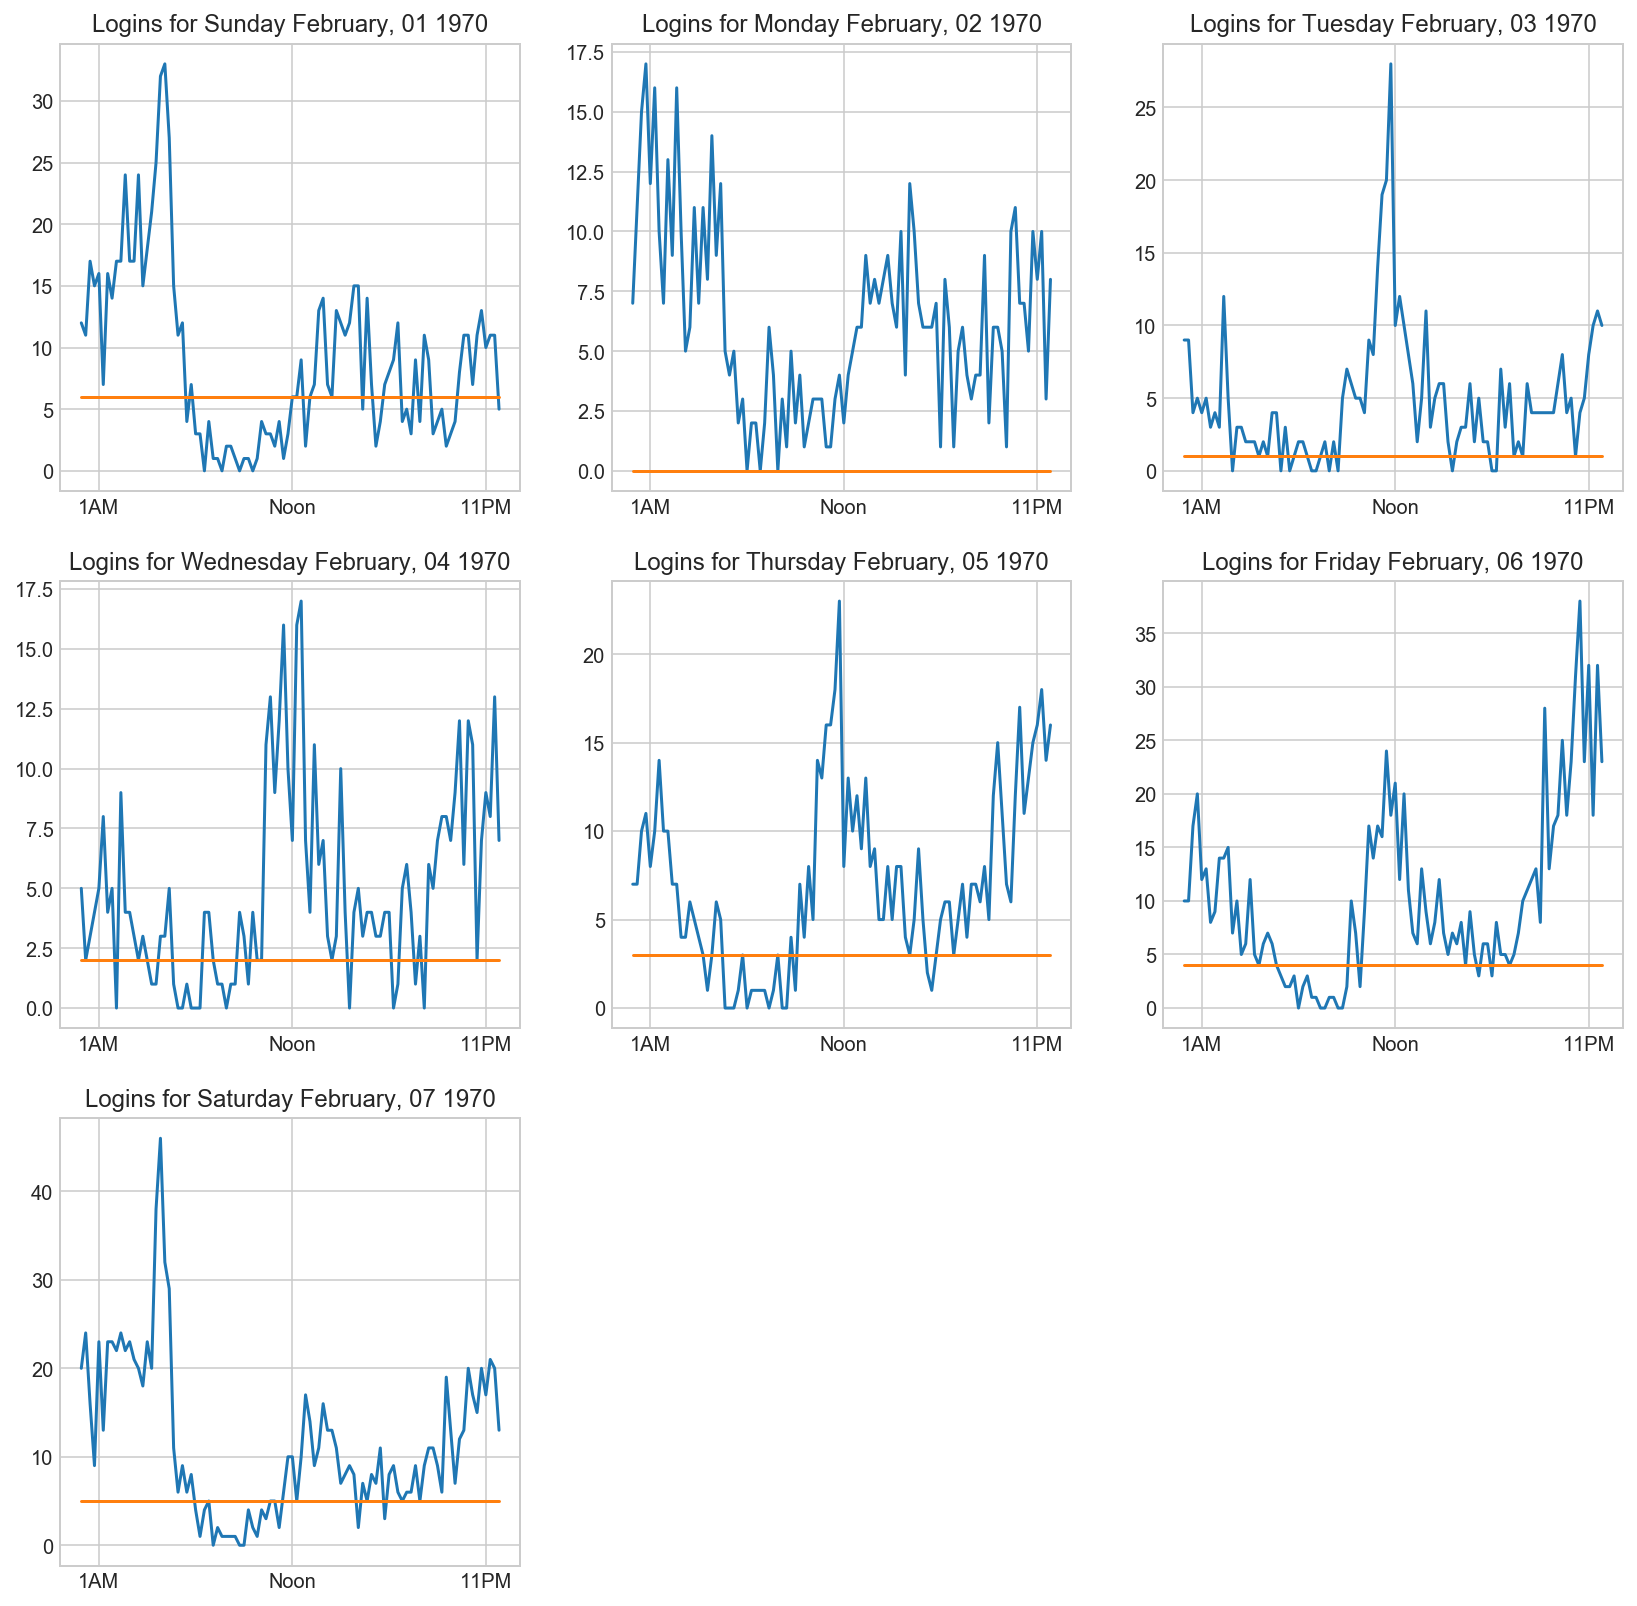

In [17]:
plot_one_week('1970-02-01')

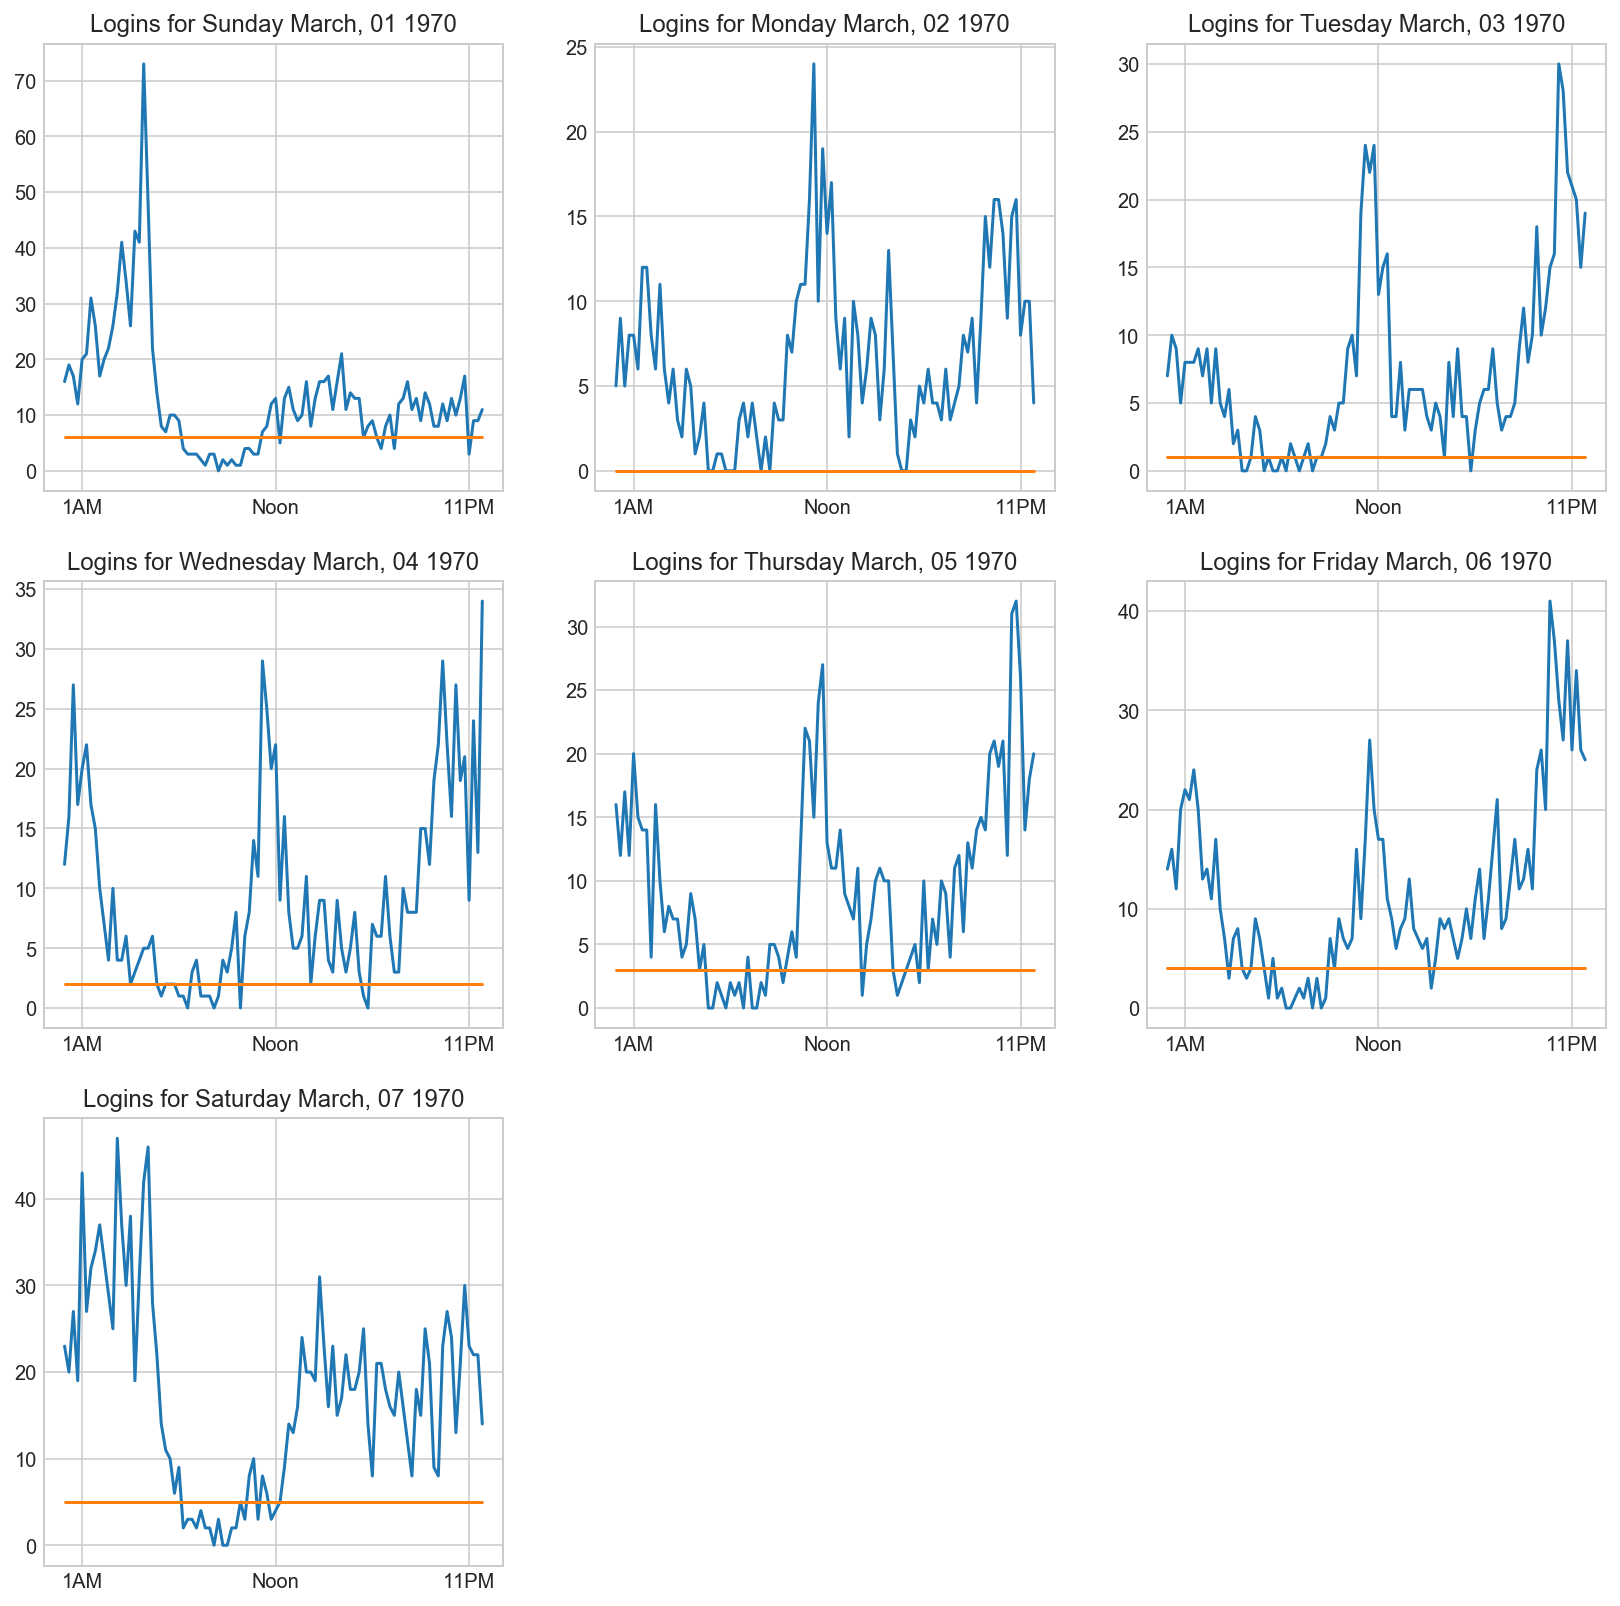

In [18]:
plot_one_week('1970-03-01')

# Daily Cycle Analysis
Looking at the `plot_one_week` function output, we can see that there is a realiable spike in logins around the noon hour. As working users are presumably requiring transportation during their lunch breaks. On the weekends we can see more realiable spikes in the early morning as users are presumably finding transportation home after a night out. These weekend spikes tend to begin early Friday evening and decline early Monday morning.

****
# PART 2
## Experiment and metrics design
****

![experiment](experiment.png)

- Assuming that the surge in rider requests warants the need for more drivers, we can assume that drivers would  